## 📘 Baseline models for predicting the Weighted Quadratic Mean (WQM)

In this notebook, we train and evaluate baseline regression models for predicting the **Weighted Quadratic Mean (WQM)**, a water quality index derived from sensor data.

We use the **`lazypredict`** library to rapidly train and benchmark a diverse set of standard machine learning models. These models are trained and evaluated using the **same time frame and data slices** previously used for training and testing the Kolmogorov–Arnold Network (KAN) model. This ensures a fair and consistent comparison.

After evaluating the full set of models, we will select the **top three performers** based on validation metrics (e.g., $R^2$, MAE, RMSE). These top models will serve as **baseline regressors** for benchmarking the performance of the KAN model.

Performance is assessed using the **same temporal cross-validation strategy** applied to the KAN:

* A **held-out test window** (temporally separated from training)
* **K-fold evaluation** using **sliding temporal windows** to quantify generalization over time

Feature selection was guided by prior analysis using **cross-correlation** and **mutual information (MI)** with the WQM target. Based on these results, the most relevant predictors were:

* **pH**
* **Water temperature**

These two variables will be used as the input feature set for all baseline models.


In [1]:
# === Path and system setup ===
from pathlib import Path
import sys

# === Step 1: Manually set project root ===
PROJECT_ROOT = Path().resolve().parents[0]

# === Step 2: Add project root to sys.path if not already present ===
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# === Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
from matplotlib import rc
from datetime import datetime, timedelta

# Lazypredict and sci
# import lazypredict
from lazypredict.Supervised import LazyRegressor

# === Project imports ===
from scripts.plot_setup import configure_plots
from scripts.preprocessing import aggregate_df_by_time

# === Import KAN models ===
import torch
from kan import KAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Plotting configuration ===
_ = configure_plots()

# === Set seed globaly ===
from scripts.reproducibility import set_global_seed

seed = 42
set_global_seed(seed)

## 🧪 Training baseline models

In this section, we load the dataset used for training and selecting baseline models. These models will be trained on an initial **6-day segment** of data and then evaluated on the **remaining \~2-day segment**. This setup mirrors the data partitioning used for training and testing the KAN model, ensuring a consistent and fair comparison.

The goal is to establish baseline performance using standard machine learning regressors, which will later be compared against the symbolic and interpretable KAN predictions.



In [2]:
# 📂 Load water quality dataset used for train baseline models
pd.set_option('display.float_format', '{:.3f}'.format)

# Define the relative path to the processed data file
path2file = Path('data/processed')
filename = Path('clean_filtered_pond_iot_2023.csv')

# Load the CSV file into a DataFrame
df_WQ = pd.read_csv(PROJECT_ROOT / path2file / filename)

# Display the loaded DataFrame (optional preview)
df_WQ.head()



,Unnamed: 0,created_date,water_pH,TDS,water_temp,WA_WQI,WQM,RMS_WQI
0,0,2023-01-30 12:00:00,6.448,287.600,23.880,12.215,21.207,12.244
1,1,2023-01-30 12:01:00,6.444,287.615,23.880,12.153,21.257,12.273
2,2,2023-01-30 12:02:00,6.447,287.622,23.880,12.198,21.221,12.252
3,3,2023-01-30 12:03:00,6.445,290.990,23.880,12.163,21.243,12.265
4,4,2023-01-30 12:04:00,6.440,290.930,23.880,12.071,21.316,12.307


In [3]:
# -----------------------------------------------------------
# 📊 Extract Input and Output Data for Regression Models
# -----------------------------------------------------------

from scripts.preprocessing import compute_quality_ratings

water_pH, TDS, water_temp = df_WQ['water_pH'].values, df_WQ['TDS'].values, df_WQ['water_temp'].values

# ======== Here we will use quality ratings as KAN inputs
# Compute quality ratings (q_i)
q_pH, _ , q_Temp = compute_quality_ratings(water_pH, TDS, water_temp)

# 🔹 Input Variables (features):
# Select the columns to be used as predictors for WQI
# These represent environmental water quality measurements
xData = np.array([q_pH, q_Temp]).T#/100

# 🔹 Output Variable (target):
# The Weighted Quadratic Mean (WQM)
# This is the value we want to model via symbolic regression
wqi_type = 'WQM' 
yData = df_WQ[wqi_type].values

# 🔹 Timestamp:
# Extract datetime for each observation to support temporal slicing
date = pd.to_datetime(df_WQ['created_date'].values)

# Total number of samples in the dataset
nsamples = len(yData)

# -----------------------------------------------------------
# 🔁 Split data into Training, Validation, and Testing Sets
# -----------------------------------------------------------

# Assuming time-ordered data sampled at 1-minute resolution
samples_per_day = 24 * 60  # 1 day = 1440 samples

# Define durations
n_train = samples_per_day * 6       # 6 days for training
n_val = nsamples - n_train

# Optional check
assert n_val > 0, "Not enough samples to allocate test set after train and validation splits."

# Training set
x_train = xData[:n_train, :]
y_train = yData[:n_train]
date_train = date[:n_train]

# Validation set
x_val = xData[n_train:, :]
y_val = yData[n_train:]
date_val = date[n_train:]


print(f'Split: Train {n_train}, Validation {n_val}. Hold-out train ratio: {n_train/nsamples:.2f}, validation ratio: {n_val/nsamples:.2f}')

Split: Train 8640, Validation 4321. Hold-out train ratio: 0.67, validation ratio: 0.33


In [ ]:
from lazypredict.Supervised import LazyRegressor
from sklearn.utils import all_estimators
# from sklearn.base import RegressorMixin

# ✅ Keep reliable regressors that are known to work well and fast
chosen_regressors = [
    'LinearRegression',
    'Ridge',
    'Lasso',
    'ElasticNet',
    'SVR',
    'LinearSVR',
    'KNeighborsRegressor',
    'RandomForestRegressor',
    'ExtraTreesRegressor',
    'ExtraTreeRegressor',
    'GradientBoostingRegressor',
    'BaggingRegressor',
    'HistGradientBoostingRegressor',
    'DecisionTreeRegressor',
    'MLPRegressor'
]


# ✅ Filter the regressors explicitly
REGRESSORS = [
    est for est in all_estimators(type_filter='regressor')
    if est[0] in chosen_regressors
]

# Initialize LazyRegressor with filtered list
reg = LazyRegressor(verbose=0, ignore_warnings=True, regressors=REGRESSORS)

# Fit using your existing train/validation data
models, predictions = reg.fit(x_train, x_val, y_train, y_val)

models


'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
MLPRegressor,0.998,0.998,0.453,6.389
RandomForestRegressor,0.882,0.882,3.464,1.096
BaggingRegressor,0.880,0.880,3.499,0.133
DecisionTreeRegressor,0.879,0.879,3.517,0.031
SVR,0.876,0.877,3.550,0.546
GradientBoostingRegressor,0.876,0.876,3.558,0.366
Lasso,0.857,0.857,3.820,0.006
KNeighborsRegressor,0.850,0.850,3.917,0.021
HistGradientBoostingRegressor,0.840,0.840,4.045,0.465


### Getting Model Objects

- 3 Top baseline models

In [5]:
# Get all trained models
model_dictionary = reg.provide_models(x_train, x_val, y_train, y_val)

# Step 1: Get the top 3 model names based on R-Squared score
top_models = models.sort_values(by='R-Squared', ascending=False).head(3)
top_model_names = top_models.index.tolist()  # or use .Model if it's a column, adjust accordingly

# Step 2: Extract the fitted models from regressor dictionary
top_model_objects = {name: model_dictionary[name] for name in top_model_names}

In [6]:
from scripts.evaluation import compute_metrics

# === Load kan models ====
from models.symbolic_regressor_2D import SymbolicKANRegressor

path_kan_model = "./case-study_02/pruned_model/prune_kan"

kan_model = KAN.loadckpt(path_kan_model)

# Add symbolic function and trained pruned kan predictors to list
top_model_objects["KAN-Symbolic"] = SymbolicKANRegressor()
top_model_objects["KAN-Model"] = None

# 🔹 Prepare a list to collect performance results
top_model_results = []

# Extract inputs and outputs for current fold
# x_val = x_val
y_val_true = y_val

# 🔁 Loop through each of the top trained models
for model_name, model in top_model_objects.items():
        # Predict using current model
        if model_name == "KAN-Model":
            x_val = torch.tensor(x_val, dtype=torch.float32)
            y_val_pred = kan_model.forward(x_val).detach().cpu().numpy()
        else:
             y_val_pred = model.predict(x_val)

        # Evaluate performance
        r2, mae, rmse = compute_metrics(y_val_true, y_val_pred)

        # Append fold result
        top_model_results.append({
            'Model': model_name,
            'R2': r2,
            'MAE': mae,
            'RMSE': rmse
        })

# 🔚 Finalize results into a DataFrame
top_model_performance = pd.DataFrame(top_model_results)
top_model_performance.sort_values(by='R2', ascending=False, inplace=True)

print('Performance on hold-out test set')
top_model_performance.reset_index(drop=True, inplace=True)

# Create path
filename = '03_baseline_performance_WQM.csv'
folder = 'models/model_cards'
path_folder = PROJECT_ROOT/Path(folder)/Path(filename)

# Save the csv
top_model_performance.to_csv(path_folder)

top_model_performance

Performance on hold-out test set


,Model,R2,MAE,RMSE
0,KAN-Symbolic,1.000,0.169,0.201
1,MLPRegressor,0.998,0.241,0.453
2,KAN-Model,0.985,0.585,1.250
3,RandomForestRegressor,0.882,2.071,3.464
4,BaggingRegressor,0.880,2.115,3.499


## Cross Validate the top 3 regressors 

In [7]:
# 📂 Load water quality dataset used for cross validation

# Define the relative path to the processed data file
path2file = Path('data/processed')
filename = Path('clean_filtered_pond_iot_2023_crossvalidation.csv')

# Load the CSV file into a DataFrame
df_WQ = pd.read_csv(PROJECT_ROOT / path2file / filename)

# Display the loaded DataFrame (optional preview)
df_WQ.head()


,Unnamed: 0,created_date,water_pH,TDS,water_temp,WA_WQI,WQM,RMS_WQI
0,0,2023-03-04 00:00:00,7.181,487.333,23.847,23.912,16.812,9.706
1,1,2023-03-04 00:01:00,7.180,487.310,23.847,23.892,16.804,9.702
2,2,2023-03-04 00:02:00,7.180,486.594,23.847,23.895,16.806,9.703
3,3,2023-03-04 00:03:00,7.181,486.508,23.846,23.900,16.800,9.700
4,4,2023-03-04 00:04:00,7.184,487.147,23.845,23.927,16.801,9.700


In [8]:
from scripts.preprocessing import select_time_slice_df
from scripts.evaluation import compute_metrics

# 🔹 Ensure 'created_date' is in datetime format
df_WQ['created_date'] = pd.to_datetime(df_WQ['created_date'])


# ===>>>>> Create a fucntion here
# 🔹 Parameters for cross-validation configuration
samples_per_day = 24 * 60               # Sampling rate = 1 sample per minute
fold_length_days = 2                    # Duration of each fold in days
step_hours = 8                          # Step size between folds in hours

fold_size = int(samples_per_day * fold_length_days)
step_size = int((step_hours / 24) * samples_per_day)

# 🔹 Compute fold indices
start_indices = np.arange(0, len(df_WQ) - fold_size + 1, step_size)
end_indices = start_indices + fold_size
num_folds = len(start_indices)
# ===>>>>> End fucntion

# 🔹 Compute quality ratings (q_i) — KAN input features
water_pH, TDS, water_temp = df_WQ['water_pH'].values, df_WQ['TDS'].values, df_WQ['water_temp'].values
q_pH, _ , q_Temp = compute_quality_ratings(water_pH, TDS, water_temp)
xData = np.array([q_pH, q_Temp]).T  # Features: (N_samples, N_features)

# 🔹 Target variable: Water Quality Index (WQI)
wqi_type = 'WQM'
yData = df_WQ[wqi_type].values

In [9]:
# 🔹 Prepare a list to collect performance results
cv_results = []

# 🔄 Loop through each validation fold
for k in range(num_folds):
    # Extract time range for current fold
    start_idx = start_indices[k]
    end_idx = end_indices[k]

    start_date = df_WQ['created_date'].iloc[start_idx]
    end_date = df_WQ['created_date'].iloc[end_idx - 1]  # inclusive

    # print(f'⏱️ Fold {k + 1}: Start = {start_date}, End = {end_date}')

    # Extract inputs and outputs for current fold
    x_val = xData[start_idx:end_idx, :]
    y_val_true = yData[start_idx:end_idx]

    # 🔁 Loop through each of the top trained models
    for model_name, model in top_model_objects.items():
        # Predict using current model
        if model_name == "KAN-Model":
            x_val = torch.tensor(x_val, dtype=torch.float32)
            y_val_pred = kan_model.forward(x_val).detach().cpu().numpy()
        else:
             y_val_pred = model.predict(x_val)

        # Evaluate performance
        r2, mae, rmse = compute_metrics(y_val_true, y_val_pred)

        # Append fold result
        cv_results.append({
            'Model': model_name,
            'Fold': k + 1,
            'Start': start_date,
            'End': end_date,
            'R2': r2,
            'MAE': mae,
            'RMSE': rmse
        })

# 🔚 Finalize results into a DataFrame
df_cv_performance = pd.DataFrame(cv_results)
# df_cv_performance.set_index('Fold', inplace=True) # We can also set index by ['Model', 'Fold']

# Sort df by Model names
# df_cv_performance = df_cv_performance.sort_values(by="Model")

# 📋 Print and Save the results
print(f"\n📊 Cross-Validation Performance Summary (target: {wqi_type}):")
# idx_best = df_cv_performance['Model'] == 'MLPRegressor'
df_cv_performance = df_cv_performance.sort_values(by=['Model', 'Fold']).reset_index(drop=True)#[idx_best]

# Create path
filename = '03a_cv-baseline_performance_WQM.csv.csv' 
folder = 'models/model_cards'
path_folder = PROJECT_ROOT/Path(folder)/Path(filename)

# Save the csv
df_cv_performance.to_csv(path_folder)
df_cv_performance


📊 Cross-Validation Performance Summary (target: WQM):


,Model,Fold,Start,End,R2,MAE,RMSE
0,BaggingRegressor,1,2023-03-04 00:00:00,2023-03-05 23:59:00,0.954,3.298,4.318
1,BaggingRegressor,2,2023-03-04 08:00:00,2023-03-06 07:59:00,0.939,3.731,4.731
2,BaggingRegressor,3,2023-03-04 16:00:00,2023-03-06 15:59:00,0.926,3.617,4.694
3,BaggingRegressor,4,2023-03-05 00:00:00,2023-03-06 23:59:00,0.886,4.901,5.986
4,BaggingRegressor,5,2023-03-05 08:00:00,2023-03-07 07:59:00,0.807,5.480,6.675
5,KAN-Model,1,2023-03-04 00:00:00,2023-03-05 23:59:00,0.965,2.354,3.775
6,KAN-Model,2,2023-03-04 08:00:00,2023-03-06 07:59:00,0.980,1.641,2.668
7,KAN-Model,3,2023-03-04 16:00:00,2023-03-06 15:59:00,0.982,1.497,2.322
8,KAN-Model,4,2023-03-05 00:00:00,2023-03-06 23:59:00,0.923,3.136,4.900
9,KAN-Model,5,2023-03-05 08:00:00,2023-03-07 07:59:00,0.745,5.195,7.664


## Compare KAN models with baseline regressors

In this section, we will compare the performance of the KAN models against baseline regressors using the temporal cross-validation results.

1. **Visualize results**:
   A comparative bar chart will be generated to show model performance, with error bars representing ±1 standard deviation (μ ± σ). The visualization will include:

   * One figure with **three subplots** (3 rows × 1 column)
   * Each subplot will correspond to one metric (R², MAE, RMSE)
   * Models will be **sorted by R² score** for consistent comparison
   * The bottom subplot will include the **model names on the x-axis**
   * All subplots will share the same x-axis (`sharex=True`)


In [14]:
# 📁 Load CV results from KAN-pruned, symbolic expression, and baseline models
# from pathlib import Path

# folder = 'models/model_cards'
# path_folder = PROJECT_ROOT / Path(folder)

# # 🔹 Load pruned symbolic KAN results
# filename_symb = 'cv_validation_performance_symb-pruned.csv'
# df_cv_symb = pd.read_csv(path_folder / filename_symb, index_col='Fold')

# # 🔹 Load full pruned KAN results
# filename_kan = 'cv_validation_performance_kan-pruned.csv'
# df_cv_kan = pd.read_csv(path_folder / filename_kan, index_col='Fold')

# 🔹 Use previously computed baseline CV results
# Assumes df_cv_performance already exists and has the same structure
# e.g., from baseline CV run with top_model_objects
# Columns: ['Model', 'Start', 'End', 'R2', 'MAE', 'RMSE']

# ✅ Merge all results into a single DataFrame
# df_cv = pd.concat([df_cv_symb, df_cv_kan, df_cv_performance])
df_cv = df_cv_performance

# 🧮 Compute per-model mean and standard deviation for performance metrics
# Group by model name and aggregate statistics
df_stats_mean = df_cv.groupby('Model')[['R2', 'MAE', 'RMSE']].mean().reset_index()
df_stats_std = df_cv.groupby('Model')[['R2', 'MAE', 'RMSE']].std().reset_index()

# 📌 Rename columns for clarity
df_stats_mean.rename(columns={'R2': 'R2_mean', 'MAE': 'MAE_mean', 'RMSE': 'RMSE_mean'}, inplace=True)
df_stats_std.rename(columns={'R2': 'R2_std', 'MAE': 'MAE_std', 'RMSE': 'RMSE_std'}, inplace=True)

# 🔗 Merge mean and std metrics into a single summary table
df_model_summary = pd.merge(df_stats_mean, df_stats_std, on='Model')

# ✅ Sort by R² descending (best models first)
df_model_summary.sort_values(by='R2_mean', ascending=False, inplace=True)
df_model_summary.reset_index(drop=True, inplace=True)

# 📊 Optional: inspect or save the summary

# Save CV temporal performance evaluation to CSV
filename = '03b_cv-baseline_summary_WQM.csv' 
folder = 'models/model_cards'
path_folder = PROJECT_ROOT/Path(folder)/Path(filename)

df_model_summary.to_csv(path_folder)

df_model_summary


,Model,R2_mean,MAE_mean,RMSE_mean,R2_std,MAE_std,RMSE_std
0,KAN-Symbolic,0.998,0.449,0.685,0.001,0.166,0.312
1,MLPRegressor,0.996,0.687,1.157,0.001,0.226,0.266
2,KAN-Model,0.919,2.764,4.266,0.100,1.507,2.152
3,RandomForestRegressor,0.904,4.141,5.218,0.059,0.947,1.021
4,BaggingRegressor,0.902,4.205,5.281,0.059,0.936,1.002


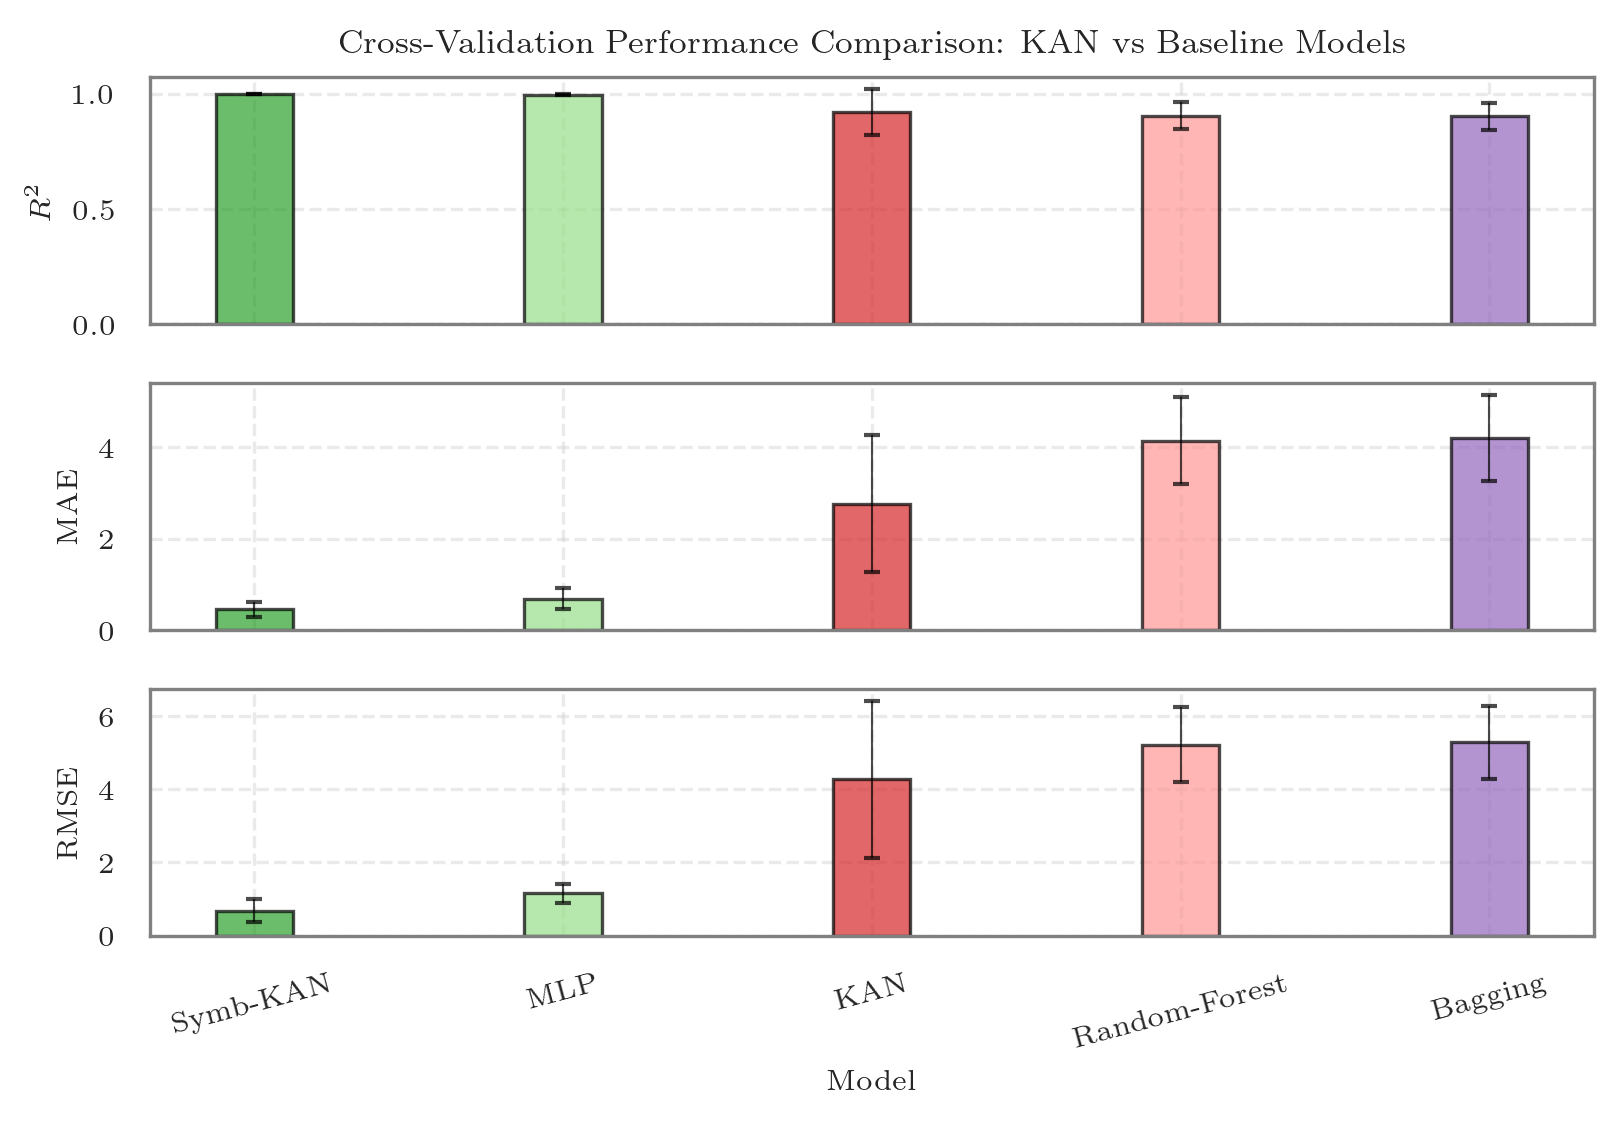

In [12]:
# Extract model names for plotting
models = df_model_summary['Model'].values

models = ['Symb-KAN', 'MLP', 'KAN' , 'Random-Forest', 'Bagging']

# Define metrics and their display names
metrics = ['R2', 'MAE', 'RMSE']
display_names = {'R2': '$R^2$', 'MAE': 'MAE', 'RMSE': 'RMSE'}

# 🎨 Define distinct colors per model
cmap = plt.get_cmap("tab20")  # Up to 20 unique colors
colors = [cmap(i+4 % 20) for i in range(len(models))]

# 📊 Create figure and axes
fig, axes = plt.subplots(3, 1, figsize=(5.5, 4), sharex=True)

idx_bars = np.array(range(len(models))) 

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # Extract mean and std for each metric
    means = df_model_summary[f'{metric}_mean'].values
    stds = df_model_summary[f'{metric}_std'].values

    # Bar plot with error bars, each with a distinct color and adjustable width
    bars = ax.bar(idx_bars, means,
        color=colors, alpha=0.7, edgecolor='black',
        width=0.25  # 🔧 Adjust this value to control bar width (default is 0.8)
    )

    ax.errorbar(idx_bars, means,
                yerr=stds,  fmt = 'none', color='black', linewidth = 0.5, alpha=0.7
    )
   
    ax.set_ylabel(display_names[metric], fontsize=7)
    ax.grid(True, linestyle='--', alpha=0.4)
 

# 🏷️ Title on top subplot
axes[0].axhline(0, color='black', linestyle='dashed', linewidth=0.5)
axes[0].set_title('Cross-Validation Performance Comparison: KAN vs Baseline Models', fontsize=8, weight='bold')

# 🏷️ Model names on bottom subplot
axes[-1].set_xticks(idx_bars)
axes[-1].set_xticklabels(models, rotation=15, ha='center')
axes[-1].set_xlabel('Model', fontsize=7)

# Save to Results directory
results_fig_dir = PROJECT_ROOT/Path('results/figures')

plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
fig_path = results_fig_dir / '16_CV_Baseline.pdf'
fig.savefig(fig_path, format='pdf', dpi=600)

plt.show()

### ⚠️ **Note on LazyPredict Compatibility**

> When using `scikit-learn==1.1.3` (as required for compatibility with PyKAN under Python 3.9.7), you must ensure that **`lazypredict==0.2.12`** is installed.

Later versions of `lazypredict` (e.g., `0.2.16`) rely on features introduced in `scikit-learn>=1.2` — specifically, the `sparse_output` parameter in `OneHotEncoder`, which is **not available** in `scikit-learn==1.1.3`.
Attempting to use a newer version of `lazypredict` with this older `scikit-learn` will result in a `TypeError`.

✅ To ensure compatibility, include the following versions in your `requirements.txt`:

```txt
scikit-learn==1.1.3
lazypredict==0.2.12
```

🛠️ If you need to reinstall:

```bash
pip uninstall lazypredict -y
pip install lazypredict==0.2.12
```
